In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from __future__ import print_function
from time import time
import datetime
import logging
import matplotlib
import matplotlib.pyplot as plt

from pandas import Series, DataFrame
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

%matplotlib inline


In [2]:
def load_data():
    dataframe = pd.read_csv('data/train_sample.csv')
    df_reindex = dataframe.reindex(np.random.permutation(dataframe.index))
    return df_reindex

def clean_data(data):
    '''
    remove unwanted colums, convert catagorical data into numeric data
    dimension : 2d -> 1 , 3d -> 0
    definition :: hd -> 1 , sd -> 0
    caption : True -> 1 , False -> 0
    licensedContent : True -> 1 , False -> 0
    '''
    data['dimension'] = (data['dimension'] == '2d')*1
    data['definition'] = (data['definition'] == 'hd')*1
    data['caption'] = (data['caption'])*1
    data['licensedContent'] = (data['licensedContent'])*1
    return data

def remove_irrelavent_features(data):
    #As we can see from the feature Importances that "favoriteCount" and "dimension" have 0 importance. So we can just ignore these features
    df = data.drop('favoriteCount',axis = 1 )
    df = df.drop('dimension',axis = 1 )
    return df

def clean_duration(input_data):
    duration = input_data["duration"]
    duration2 = input_data["duration"]
    #duration_df = pd.DataFrame(duration2)
    #print duration
    duration_time = duration.str.split('PT')
    test1 = duration_time.str[1]
    #print test1
    duration_dummy = duration
    test2 = test1.str.split('S').str[0]

    seconds = test2.str.split('M').str[1]
    seconds[:] = ['00' if x == '' else x for x in seconds]
    seconds[:] = ['00' if x == 'nan' else x for x in seconds]
    #print '\n\nSECONDS'
    #print seconds

    test3 = test2.str.split('M').str[0]
    minutes = test1

    minutes[:] = [x.split('H')[1] if 'H' in x else x for x in test3]
    minutes[:] = ['00' if x == '' or x == 'nan' else x for x in minutes]
    minutes[:] = ['00' if x == 'nan' else x for x in minutes]
    hours = duration_dummy

    hours[:] = [x.split('H')[0] if 'H' in x else '00' for x in test3]
    hours[:] = ['00' if x == '' or x == 'nan' else x for x in hours]
    hours[:] = ['00' if x == 'nan' else x for x in hours]

    minutes_in_sec = list()
    minutes_in_sec [:] = [int(x)*60 for x in minutes]

    hours_in_sec = list()
    hours_in_sec [:] = [int(x)*3600 for x in hours]

    duration_in_sec = list()

    for i in range(len(duration)):
        duration_in_sec.append(hours_in_sec[i]+minutes_in_sec[i]+int(seconds[i]))

    #duration_df['duration_in_sec'] = duration_in_sec
    #category = input_data['video_category_id']
    #duration_df['video_category_id'] = category
    input_data['duration_in_sec'] = duration_in_sec
    return input_data


def clean_published(input_data):
    published=input_data['published_at']
    date_string_1=published.str.split('.').str[0]

    date1=date_string_1.str.split('T').str[0]
    time1=date_string_1.str.split('T').str[1]

    published_dates=date1 + " " + time1
    
    published_dates = pd.to_datetime(published_dates)
    input_data['published_date'] = published_dates  
    
    input_data['weekday'] = np.where(input_data['published_date'].dt.dayofweek <= 4, 1, 0)
    #published_df['weekend'] = np.where(published_df['published_date'].dt.dayofweek <= 4, 0, 1)
    input_data['quarter'] = input_data['published_date'].dt.quarter

    #Winter is Dec-Feb   Spring is Mar-Apr    Summer is May-Aug    Fall is Sep-Nov
    input_data['winter'] = input_data.published_date.dt.month.map( lambda x: 1 if x == 12 or x == 1 or x == 2 else 0)
    input_data['summer'] = input_data.published_date.dt.month.map( lambda x: 1 if x == 5 or x == 6 or x == 7 or x == 8 else 0)
    input_data['spring'] = input_data.published_date.dt.month.map( lambda x: 1 if x == 3 or x == 4 else 0)
    input_data['fall'] = input_data.published_date.dt.month.map( lambda x: 1 if x == 9 or x == 10 or x == 11 else 0)

    input_data['is_month_start'] = np.where(input_data['published_date'].dt.is_month_start == True, 1, 0)
    input_data['is_month_end'] = np.where(input_data['published_date'].dt.is_month_end == True, 1, 0)

    input_data['late_night'] = input_data.published_date.dt.hour.map( lambda x: 1 if x > 0 and x < 6 else 0)
    input_data['early_morning'] = input_data.published_date.dt.hour.map( lambda x: 1 if x > 5 and x < 12 else 0)
    input_data['day'] = input_data.published_date.dt.hour.map( lambda x: 1 if x > 11 and x < 18 else 0)
    input_data['night'] = input_data.published_date.dt.hour.map( lambda x: 1 if x > 17 else 0)
    
    dt1 = datetime.datetime.strptime('2015-12-10', "%Y-%m-%d")
    input_data['new_date'] = dt1 - input_data['published_date']
    age = list()
    for i in range(len(published)):
        age.append(int(str(input_data['new_date'][i]).split(' ')[0]))
    input_data['age'] = age
    return input_data


In [3]:
firstLoad_df = load_data()
cleaned_df = clean_data(firstLoad_df)
cleaned_df = remove_irrelavent_features(cleaned_df)
durationCleaned_df = clean_duration(cleaned_df)
publish_df = clean_published(durationCleaned_df)

/Users/NikitaAmartya/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
publish_df['description'].fillna('No description', inplace=True)
working_df = publish_df

In [5]:
# Split into train-test data set
target_var = "video_category_id"
predictor_var = ["title", "description", "viewCount", 
                 "likeCount", "dislikeCount","commentCount",
                 "definition", "caption","duration_in_sec",
                 "weekday", "quarter", "winter","summer","spring",
                 "fall","late_night","early_morning","day","night",
                 "is_month_start","is_month_end","age"]  

X = working_df[[x for x in working_df.columns if x in predictor_var]]
Y = working_df[[x for x in working_df.columns if x in target_var]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.80, random_state = 10)

In [6]:
numeric_cols = ["viewCount", "likeCount", "dislikeCount","commentCount", "definition", 
                "caption","duration_in_sec", "weekday", "quarter", "winter","summer",
                "spring","fall","late_night","early_morning","day","night","is_month_start","is_month_end","age"]

X_train_text = X_train[[x for x in X_train.columns if x in ('title', 'description')]]
X_train_numeric = X_train[[x for x in X_train.columns if x in numeric_cols]]

X_test_text = X_test[[x for x in X_test.columns if x in ('title', 'description')]]
X_test_numeric =  X_test[[x for x in X_test.columns if x in numeric_cols]]


In [56]:
def binary_tree_analysis(X_train, Y_train, X_test, Y_test):
        
    decision_tree = DecisionTreeClassifier(criterion="entropy", min_samples_split= 2, min_samples_leaf= 128 )
    decision_tree.fit(X_train, Y_train)
    #plot importance graph
    columnList = [x for x in X_train.columns]
    f_importance = DataFrame(decision_tree.feature_importances_, columns = ["Importance"],
                         index = columnList).sort(['Importance'], ascending = False)
    plt.figure() 
    f_importance.plot(kind='bar');
    
    print ("Accuracy on train df = %.3f" % metrics.accuracy_score(decision_tree.predict(X_train), Y_train))
    print ("Accuracy on test df = %.3f" % metrics.accuracy_score(decision_tree.predict(X_test), Y_test))
    result_numeric_test = decision_tree.predict(X_test)
    return decision_tree

Accuracy on train df = 0.311
Accuracy on test df = 0.289


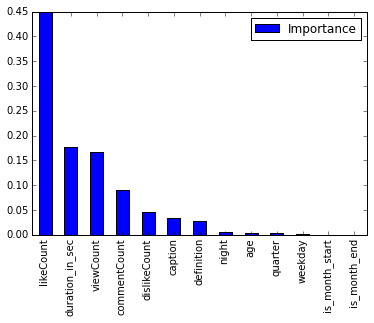

In [57]:
tree_numeric = binary_tree_analysis(X_train_numeric, Y_train, X_test_numeric, Y_test)

result_numeric_train = tree_numeric.predict(X_train_numeric)
result_numeric_test = tree_numeric.predict(X_test_numeric)

In [21]:
#DROP THE UNWANTED COLUMNS

columns_to_drop = ["winter","summer","spring","fall","late_night",
                   "early_morning","day","is_month_start","is_month_end"]  
for x in columns_to_drop :
    X_train_numeric.drop(x, axis=1, inplace=True)
    X_test_numeric.drop(x, axis=1, inplace=True)

/Users/NikitaAmartya/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/NikitaAmartya/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_analysis(X_train_numeric, Y_train, X_test_numeric, Y_test):
        
    random_forest = RandomForestClassifier(min_samples_split= 2 ,min_samples_leaf= 128, n_estimators = 30)
    random_forest.fit(X_train_numeric, Y_train)

    #Feature Importances
    #importances = decision_tree.feature_importances_
    #x_values=np.arange(1,21)
    #plt.figure(figsize=(8,15))
    #plt.bar(x_values,importances)
    #plt.xticks(x_values,numeric_cols, rotation='vertical')
    #plt.show()
    
    print ("Accuracy on train df = %.3f" % metrics.accuracy_score(random_forest.predict(X_train_numeric), Y_train))
    print ("Accuracy on test df = %.3f" % metrics.accuracy_score(random_forest.predict(X_test_numeric), Y_test))
    #print X_train_numeric.corr()
    
    return random_forest.predict(X_train_numeric)

In [15]:
result_numeric = random_forest_analysis(X_train_numeric, Y_train, X_test_numeric, Y_test)

Accuracy on train df = 0.326
Accuracy on test df = 0.305


/Users/NikitaAmartya/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


########### Code in next 6 cells needs work ########

In [16]:
#TODO
# Grid Search function --> Testing one pipeline for various parameters

def performGridSearch(X_train, Y_train, model, pipeline, parameters):
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    
    print("Performing grid search for {}".format(model))
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    prob_title = grid_search.fit(X_train, Y_train)

    print()

    print("Best score for %s : %0.3f" % (model, grid_search.best_score_))
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    return grid_search

In [17]:
#TODO
# Test various model in performGridSearchCV 

def compareModelsGridSearch(X_train, Y_train, model_list, pipeline_list, parameters_list):
    
    for i in range(len(model_list)):
        performGridSearch(X_train, Y_train, model_list[i], pipeline[i], parameters[i])
    
    return True

In [18]:
# I am not sure about its usage with gridsearchcv
corpus_title = X_train_text['title'].values.tolist()
corpus_description = X_train_text['description'].values.tolist()

In [19]:
# create pipelines and parameters here

pipeline = Pipeline([    
    ('vect', CountVectorizer()),      
    ('tfidf', TfidfTransformer()),    
    ('clf', SGDClassifier()),        
    #('logreg', LogisticRegression()),        
    #('classifier', MultinomialNB())       
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
}

In [20]:
grid_search_title = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    
print("Performing grid search for title...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
prob_title = grid_search_title.fit(X_train_text['title'], Y_train['video_category_id'])
    
print("done in %0.3fs" % (time() - t0))
print()

print("Best score for title: %0.3f" % grid_search_title.best_score_)
print("Best parameters set:")
best_parameters_title = grid_search_title.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters_title[param_name]))

Performing grid search for title...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  66 out of  72 | elapsed:  5.6min remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.0min finished


done in 378.527s

Best score for title: 0.652
Best parameters set:
	clf__alpha: 1e-05
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [23]:
grid_search_description = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
print("Performing grid search for description...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
prob_description = grid_search_description.fit(X_train_text['description'], Y_train['video_category_id'])
print("done in %0.3fs" % (time() - t0))
print() 
print("Best score for description: %0.3f" % grid_search_description.best_score_)
print("Best parameters set:")
best_parameters_description = grid_search_description.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters_description[param_name]))

Performing grid search for description...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  66 out of  72 | elapsed: 12.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 13.6min finished


done in 856.861s

Best score for description: 0.683
Best parameters set:
	clf__alpha: 1e-05
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [24]:
result_title_train = grid_search_title.predict(X_train_text['title'])
result_title_test = grid_search_title.predict(X_test_text['title'])

In [25]:
result_description_train = grid_search_title.predict(X_train_text['description'])
result_description_test = grid_search_title.predict(X_test_text['description'])

In [26]:
def createFinalDataFrame(numeric,title,description,original_Y):
    df_n = pd.DataFrame(numeric)
    df_n.columns = ['numericP']
    df_t = pd.DataFrame(title)
    df_t.columns = ['titleP']
    df_d = pd.DataFrame(description)
    df_d.columns = ['descriptionP']
    df_y = original_Y
    resetdf_y = df_y.reset_index()
    result_df = pd.concat([df_n, df_t, df_d, resetdf_y], axis=1)
    return result_df


In [27]:
result_train = createFinalDataFrame(result_numeric_train,result_title_train,result_description_train,Y_train)
result_test = createFinalDataFrame(result_numeric_test,result_title_test,result_description_test,Y_test)

In [54]:
target_var = "video_category_id"
predictor_var = ['numericP','titleP','descriptionP']
X_train = result_train[[x for x in result_train.columns if x in predictor_var]]
Y_train = result_train[[x for x in result_train.columns if x in target_var]]
    
X_test = result_test[[x for x in result_test.columns if x in predictor_var]]
Y_test = result_test[[x for x in result_test.columns if x in target_var]]   

Accuracy on train df = 0.942
Accuracy on test df = 0.665


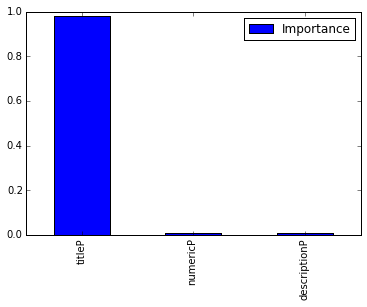

In [58]:
final_result = binary_tree_analysis(X_train,Y_train,X_test,Y_test)